In [1]:
import pandas as pd
import glob
import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot

## Read Data

In [2]:
# Add past year's data
path = 'C:/Users/sutantoy/Downloads/rooroo/csv'
all_files = glob.glob(path + "/*.csv")

li = []

for file in all_files:
    file_df = pd.read_csv(file)
    
    area = file.split('\\')[1].replace('.csv','')
    file_df['area'] = area
    
    li.append(file_df)

df = pd.concat(li, axis=0, ignore_index=True)
common_cols = ['block', 'street name', 'lease commence year'] # 'lease commence year' corr to 'remaining lease (yr)'
df.drop(columns=common_cols, inplace=True)

# Add even more historical data
hist_path = 'C:/Users/sutantoy/Downloads/rooroo/Jan2017ToOct2020'
hist_all_files = glob.glob(hist_path + "/*.csv")

hist_li = []

for file in hist_all_files:
    file_df = pd.read_csv(file)
    
    area = file.split('\\')[1].replace('.csv','')
    file_df['area'] = area
    
    hist_li.append(file_df)

hist_df = pd.concat(hist_li, axis=0, ignore_index=True)
hist_df.drop(columns=common_cols + ['rank town', 'flat type'], inplace=True)

df = df.append(hist_df)
del hist_df

mapping = {'01 to 03': 2, 
           '04 to 06': 5, 
           '07 to 09': 8, 
           '10 to 12': 11, 
           '13 to 15': 14, 
           '16 to 18': 17, 
           '19 to 21': 20,
           '22 to 24': 23,
           '25 to 27': 26,
           '28 to 30': 29,
           '31 to 33': 36,
           '34 to 36': 35,
           '37 to 39': 38,
           '40 to 42': 41,
           '43 to 45': 44,
           '46 to 48': 47,
           '01 TO 03': 2, 
           '04 TO 06': 5, 
           '07 TO 09': 8, 
           '10 TO 12': 11, 
           '13 TO 15': 14, 
           '16 TO 18': 17, 
           '19 TO 21': 20,
           '22 TO 24': 23,
           '25 TO 27': 26,
           '28 TO 30': 29,
           '31 TO 33': 36,
           '34 TO 36': 35,
           '37 TO 39': 38,
           '40 TO 42': 41,
           '43 TO 45': 44,
           '46 TO 48': 47}
df['storey'] = df['storey'].map(mapping)

df = df[df['storey'] >= 16]

ts_df = df

df=df.drop(columns=['resale registration date'])

display(df.head())
print(df.shape)

,storey,floor area (sqm),flat model,remaining lease (yr),resale price ($),area
74,26,70,Model A,90.00,530000,Ang Mo Kio
225,26,70,Model A,90.33,543000,Ang Mo Kio
299,17,67,Model A,93.67,455000,Ang Mo Kio
342,20,67,Model A,93.75,473000,Ang Mo Kio
344,29,70,Model A,90.58,510000,Ang Mo Kio


(863, 6)


## Time Series

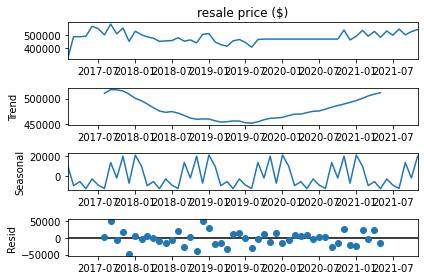

In [3]:
ts_df['resale registration date'] = pd.to_datetime(ts_df['resale registration date'])
ts_df = ts_df.groupby(by='resale registration date').mean()
ts_df = ts_df.asfreq('MS', method='ffill')
result = seasonal_decompose(ts_df['resale price ($)'])
result.plot()
pyplot.show()

## Traditional Regression

In [4]:
df.corr()

,storey,floor area (sqm),remaining lease (yr),resale price ($)
storey,1.000000,-0.098248,0.541868,0.609092
floor area (sqm),-0.098248,1.000000,-0.095300,-0.043387
remaining lease (yr),0.541868,-0.095300,1.000000,0.816810
resale price ($),0.609092,-0.043387,0.816810,1.000000


In [5]:
x = df.drop(columns = 'resale price ($)')
x = pd.get_dummies(x)
y = df[['resale price ($)']]

In [6]:
lr = sm.OLS(y,x)
lr.fit().summary2().tables

[                     0                 1                    2           3
 0               Model:               OLS      Adj. R-squared:       0.876
 1  Dependent Variable:  resale price ($)                 AIC:  20795.0549
 2                Date:  2021-11-26 17:26                 BIC:  20880.7424
 3    No. Observations:               863      Log-Likelihood:     -10380.
 4            Df Model:                17         F-statistic:       358.8
 5        Df Residuals:               845  Prob (F-statistic):        0.00
 6           R-squared:             0.878               Scale:  1.6727e+09,
                                       Coef.      Std.Err.          t  \
 storey                          1884.465050    254.865435   7.393961   
 floor area (sqm)                4317.185884    376.529370  11.465735   
 remaining lease (yr)            3231.094814    361.090266   8.948164   
 flat model_Dbss                 7167.552508  25989.620785   0.275785   
 flat model_Improved          -123